In [31]:
!pip install mesa

In [32]:
from mesa import Agent, Model
from mesa.time import BaseScheduler
from mesa.datacollection import DataCollector
from collections import Counter
import random
import numpy as np
import pandas as pd
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

In [33]:
#It allows for multiple output in Colaboratory
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [34]:
def computeMeanBias(model):
    biases = [agent.bias for agent in model.schedule.agents]
    return np.mean(biases)

def getRightGroupDecisionsRatio(model):
    return model.grDecisions.count(model.rightDec)/len(model.grDecisions)

def getRightIndividualDecisionsRatio(model):
    return model.decisions.count(model.rightDec)/len(model.decisions)
    
class Agent(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.bias = self.model.startBias
        self.var = self.model.variance
        self.x = 0
        self.score = 0
        self.conf = 0
        self.ds = 0
        self.dec = 0
        
    def step(self):
        self.x = np.random.normal(self.model.c + self.bias, self.var)
        self.conf = self.x/self.var
        self.ds = self.x/((self.var)**2)
        self.dec = 2 if self.x > 0 else 1
        self.model.decisions.append(self.dec)

class Model(Model):

    def __init__(self, agentsNum, decisionModel, groupSize, biasChangeRate, c, startBias, variance, minBias, maxBias, rightDec):

        self.agentsNum = agentsNum
        self.decisionModel = decisionModel
        self.groupSize = groupSize
        self.biasChangeRate = biasChangeRate
        self.cTuple = c
        self.startBias = startBias
        self.variance = variance
        self.minBias = minBias
        self.maxBias = maxBias
        self.dec = 0
        self.grDecisions = []
        self.decisions = []
        self.rightDec = rightDec
        self.schedule = BaseScheduler(self)

        # Create agents
        for i in range(self.agentsNum):
            a = Agent(i, self)
            self.schedule.add(a)

        self.datacollector = DataCollector(
        model_reporters={"Mean Bias": computeMeanBias,
                        "Group Decision": "dec",
                        "Right Group Decisions Ratio": getRightGroupDecisionsRatio,
                        "Right Individual Decisions Ratio": getRightIndividualDecisionsRatio}  
        )
            
    def makeGroupDecision(self):

        if self.decisionModel == 'Voting':
            self.dec = Counter([agent.dec for agent in self.chosenAgents]).most_common(1)[0][0]

        elif self.decisionModel == 'Random':
            self.dec = random.choice([agent.dec for agent in self.chosenAgents])

        elif self.decisionModel == 'WCS':
            self.dec = 1 if sum([agent.conf for agent in self.chosenAgents]) < 0 else 2

        elif self.decisionModel == 'DSS':
            self.dec = 1 if sum([agent.ds for agent in self.chosenAgents]) < 0 else 2

        elif self.decisionModel == 'Best Decides':
            m = max([agent.score for agent in self.chosenAgents])
            for agent in self.chosenAgents:
                 if agent.score == m: self.dec = agent.dec
                 break

        else:
            print("\nERROR: Wrong model name - " + model + " - use: Voting, Random, WCS, DSS or Best Decides")

    def update(self):

        for agent in self.chosenAgents:
            if agent.dec == self.dec:
                 agent.score += 1
            if self.dec == 2 and agent.bias + self.biasChangeRate < self.maxBias:
                 agent.bias += self.biasChangeRate
            elif self.dec == 1 and agent.bias - self.biasChangeRate  > self.minBias:
                 agent.bias -= self.biasChangeRate

    def step(self):
        '''Advance the model by one step. (n agents interact)'''
        self.chosenAgents = random.choices(self.schedule.agents, k=self.groupSize)
        self.c = np.random.normal(self.cTuple[0],self.cTuple[1])

        for agent in self.chosenAgents:
            agent.step()
   
        self.makeGroupDecision()
        self.grDecisions.append(self.dec)
        self.update()
        self.datacollector.collect(self)    

In [35]:
def runSimulation(params, steps):

    model = Model(
        
        params['agentsNum'],
        params['decisionModel'],
        params['groupSize'],
        params['biasChangeRate'],
        params['c'],
        params['startBias'],
        params['variance'],
        params['minBias'],
        params['maxBias'],
        params['rightDec']
                  
    )
    
    for i in range(steps):
        model.step()

    return model.datacollector.get_model_vars_dataframe()


def runMultipleSimulations(fixedParams, variableParams, steps, iterations):

    dic = defaultdict(lambda: defaultdict())

    def updateDic():

        dfs = []

        for i in range(iterations):

            df = runSimulation(fixedParams, steps)
            df['Step'] = range(1, df.shape[0]+1)
            dfs.append(df)

        for var, value in fixedParams.items():

            concatedDfs = pd.concat(dfs)

            if var in dic.keys():
               if value in dic[var].keys():
                   dic[var][value] = pd.concat([concatedDfs, dic[var][value]])
               else:
                   dic[var][value] = concatedDfs
            else:
              dic[var][value] = concatedDfs


    if len(variableParams) > 0:

        keys = variableParams.keys()
        values = (variableParams[key] for key in keys)
        varParamsCombinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

        for varParamsCombination in varParamsCombinations:

            fixedParams.update(varParamsCombination)
            updateDic()

    else:

        updateDic()
      
    return dic

In [36]:
steps = 100 #Number of steps of each simulation with certain parameters
iterations = 1000 #How many times each simulation with certain parameters and number of steps will be repeated

fixedParams = {
    
    "agentsNum" : 10,
    "groupSize" : 3,
    "c" : (1,1), #1st number is mean, second is variance of normal distribution from which true c will be sampled in each group interaction
    "biasChangeRate" : 0.05,
    "startBias" : 0,
    "variance" : 1,
    "minBias" : -1,
    "maxBias" : 1,
    "rightDec" : 2

}


variableParams = {
    "decisionModel": ['Random', 'WCS', 'Voting']
}


data = runMultipleSimulations(fixedParams, variableParams, steps, iterations)

In [37]:
def plot(variable, value, what):
    X = data[variable][value]['Step']
    Y = data[variable][value][what]
    plt.figure(figsize=(10,7.5))
    plt.scatter(X, Y, s = 30, edgecolors = 'none', c='tab:blue', alpha = 0.01)
    # plt.text(0.1, 0.8, value, fontsize = 23)

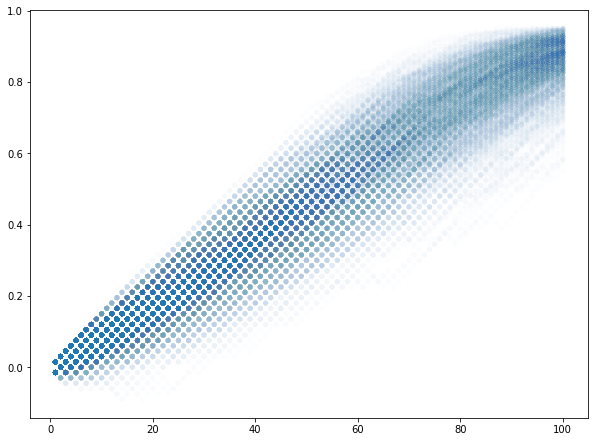

In [38]:
plot('decisionModel', 'Random', 'Mean Bias')

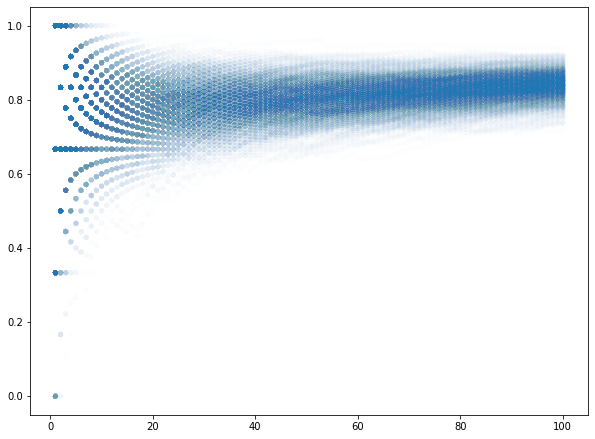

In [39]:
plot('decisionModel', 'Random', 'Right Individual Decisions Ratio')

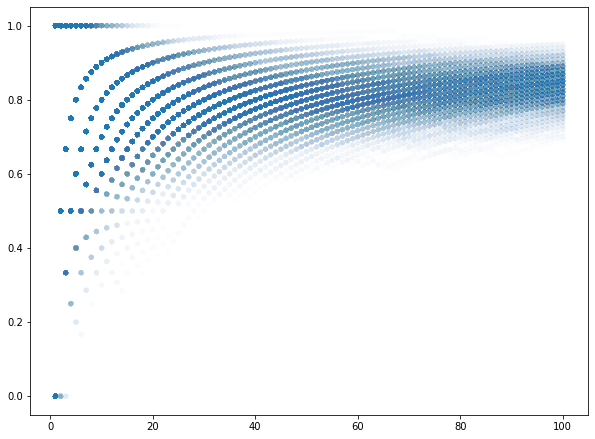

In [40]:
plot('decisionModel', 'Random', 'Right Group Decisions Ratio')

In [41]:
def plotByOneVariableParam(variable, what):

  N = len(variableParams[variable])
  size_constant = 20

  fig, axs = plt.subplots(N, figsize=(10,7.5*N))

  for i in range (N):
      X = data[variable][variableParams[variable][i]]['Step']
      Y = data[variable][variableParams[variable][i]][what]
      axs[i].scatter(X, Y, s=30, edgecolors = 'none', c = 'tab:blue', alpha = 0.01)
      axs[i].text(0.7, 0.9, variableParams[variable][i], fontsize = 23)
      # axs[i].set(xlabel = 'Step', ylabel = 'Mean Bias')
      axs[i].grid(True)


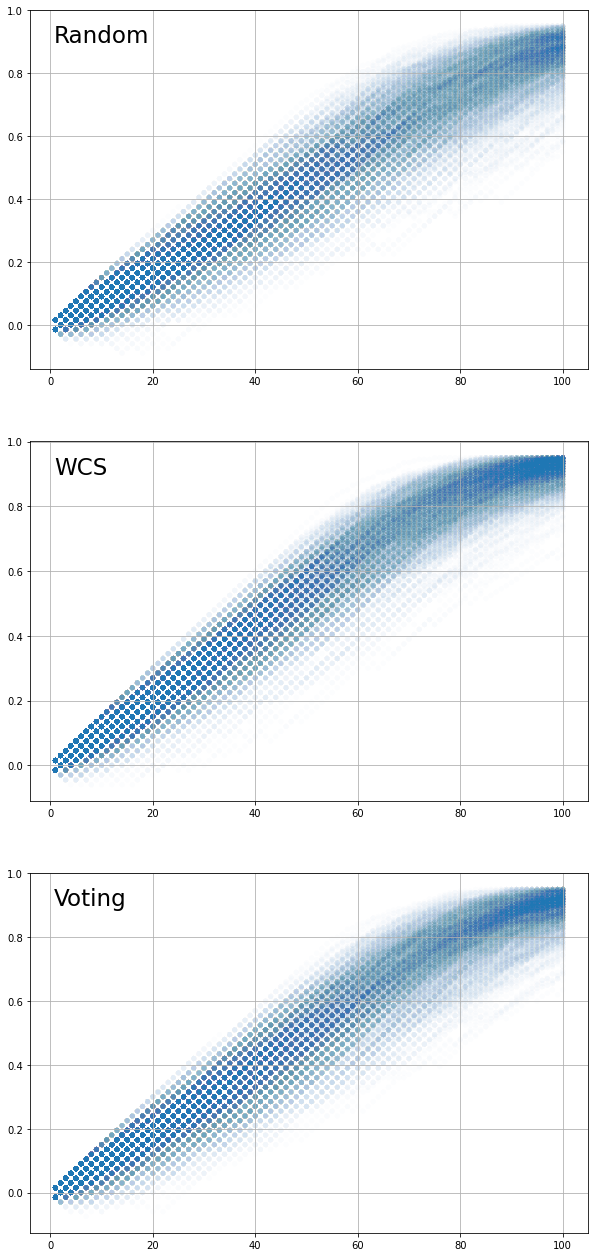

In [42]:
plotByOneVariableParam('decisionModel', 'Mean Bias')